# Libraries
---

In [56]:
import os
import gc # Garbage collection for MPS
import numpy as np
import pandas as pd
from collections import defaultdict
from time import time
import random
# Pytorch libraries (Machine Learning)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from sklearn.model_selection import train_test_split
# CWT libraries
import pywt
from tqdm import tqdm
# PSD libraries
from scipy.signal import welch
# Visualization Libraries
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
# TensorFlow Libraries
import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History

# Continuous Wavelet Transformation

We will import the files into a DataFrame and then use it to process continuous wavelet sonographs, which represent each feature as a channel, allowing us to use Convolutional Neural Networks (CNN) with pure image feature extraction algorithms. This way, we can get a better level of efficiency, but we need to compare this against data outside of our dataset, which lacks the additional two channels that we are getting from the ultrasonics

In [2]:
# CWT parameters
scales = range(1, 128)
waveletname = 'morl'

# Device setup (prefer MPS if available)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# print(os.getcwd())

def normalize_signal(data):
    return (data - data.mean(axis=0)) / (data.std(axis=0) + 1e-6)

def extract_tensor_from_csv(csv_path, target_len=127):
    # print('CSV path:')
    # print(csv_path)
    df = pd.read_csv(csv_path)
    cols = ['AccelX(g)', 'AccelY(g)', 'AccelZ(g)', 
            'GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)',
            'DistanceLeft(cm)', 'DistanceRight(cm)']
    data = df[cols].values
    data = normalize_signal(data)

    # Pad or truncate to fixed length
    if len(data) >= target_len:
        data = data[:target_len, :]
    else:
        pad_width = target_len - len(data)
        pad = np.zeros((pad_width, data.shape[1]), dtype=np.float32)
        data = np.vstack([data, pad])
        
    return data.astype(np.float32)  # Final shape: (127, 8)

def compute_cwt(signal_1d):
    coeff, _ = pywt.cwt(signal_1d.cpu().numpy(), scales, waveletname, 1)
    return torch.from_numpy(coeff[:, :127]).float().to(device)

def process_dataset_tensor(data, batch_size=32):
    num_samples, signal_length, num_channels = data.shape
    result = torch.zeros((num_samples, 127, 127, num_channels), device=device)

    for ch in range(num_channels):
        print(f"Processing channel {ch+1}/{num_channels}")
        for i in tqdm(range(0, num_samples, batch_size)):
            batch = data[i:i+batch_size, :, ch]
            batch_tensor = torch.from_numpy(batch).float().to(device)
            for k in range(batch_tensor.shape[0]):
                result[i + k, :, :, ch] = compute_cwt(batch_tensor[k])
    return result.cpu().numpy()

def load_and_split_dataset(root_dir, train_ratio=0.8, seed=42):
    samples = []
    labels = []
    label_to_index = {}
    file_paths = []

    for root, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".csv") or file.endswith(".CSV"):
                path = os.path.join(root, file)
                path_parts = os.path.normpath(root).split(os.sep)
                if len(path_parts) < 2:
                    continue
                classifier, behavior = path_parts[-2], path_parts[-1]
                label = f"{classifier}_{behavior}"
                if label not in label_to_index:
                    label_to_index[label] = len(label_to_index)
                file_paths.append((path, label_to_index[label]))

    # Shuffle and split
    paths, labels = zip(*file_paths)
    paths = np.array(paths)
    labels = np.array(labels)
    # for k, v in label_to_index.items(): print(f'Name: {k}, Label: {v}')
    import json

    # Assuming label_to_index is already populated
    with open("label_index_map.json", "w") as f:
        json.dump(label_to_index, f, indent=4)
    
    print("Label-to-index mapping saved to label_index_map.json")

    print(f'This is the number of CSV files detected: {len(paths)}')
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        paths, labels, train_size=train_ratio, random_state=seed, stratify=labels
    )

    def load_batch(paths):
        return np.stack([extract_tensor_from_csv(p) for p in paths])

    print("Loading training data...")
    train_data = load_batch(train_paths)
    print("Loading test data...")
    test_data = load_batch(test_paths)

    return train_data, train_labels, test_data, test_labels, label_to_index

# Change this to your full dataset root
full_dataset_root = "data-collections"

train_data, train_labels, test_data, test_labels, label_dict = load_and_split_dataset(full_dataset_root)

# Convert numpy arrays to tensors (optional but helpful for consistency)
raw_dataset = {
    "train_data": torch.tensor(train_data),        # shape: (N, 127, 8)
    "train_labels": torch.tensor(train_labels),    # shape: (N,)
    "test_data": torch.tensor(test_data),          # shape: (M, 127, 8)
    "test_labels": torch.tensor(test_labels),      # shape: (M,)
    "label_dict": label_dict                       # dict: str -> int
}

torch.save(raw_dataset, "raw_handgestures_dataset.pt")
print("Raw dataset saved to raw_handsgestures_dataset.pt")

print("\nProcessing CWT for training data...")
x_train = process_dataset_tensor(train_data)
y_train = train_labels[:len(x_train)]

print("\nProcessing CWT for test data...")
x_test = process_dataset_tensor(test_data)
y_test = test_labels[:len(x_test)]

print("\nCWT Processing complete. Saving data state...")
torch.save({
    "x_train": torch.tensor(x_train),
    "y_train": torch.tensor(y_train),
    "x_test": torch.tensor(x_test),
    "y_test": torch.tensor(y_test),
    "label_dict": label_dict
}, "cwt_handgestures_dataset.pt")

# Final shapes
print(f"\nx_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


Using device: mps
Label-to-index mapping saved to label_index_map.json
This is the number of CSV files detected: 19275
Loading training data...
Loading test data...
Raw dataset saved to raw_handsgestures_dataset.pt

Processing CWT for training data...
Processing channel 1/8


100%|█████████████████████████████████████████| 482/482 [00:54<00:00,  8.92it/s]


Processing channel 2/8


100%|█████████████████████████████████████████| 482/482 [00:52<00:00,  9.13it/s]


Processing channel 3/8


100%|█████████████████████████████████████████| 482/482 [00:53<00:00,  9.06it/s]


Processing channel 4/8


100%|█████████████████████████████████████████| 482/482 [00:53<00:00,  8.99it/s]


Processing channel 5/8


100%|█████████████████████████████████████████| 482/482 [00:53<00:00,  8.94it/s]


Processing channel 6/8


100%|█████████████████████████████████████████| 482/482 [00:53<00:00,  8.95it/s]


Processing channel 7/8


100%|█████████████████████████████████████████| 482/482 [00:53<00:00,  8.97it/s]


Processing channel 8/8


100%|█████████████████████████████████████████| 482/482 [00:55<00:00,  8.74it/s]



Processing CWT for test data...
Processing channel 1/8


100%|█████████████████████████████████████████| 121/121 [00:13<00:00,  8.71it/s]


Processing channel 2/8


100%|█████████████████████████████████████████| 121/121 [00:13<00:00,  8.93it/s]


Processing channel 3/8


100%|█████████████████████████████████████████| 121/121 [00:13<00:00,  8.93it/s]


Processing channel 4/8


100%|█████████████████████████████████████████| 121/121 [00:13<00:00,  8.98it/s]


Processing channel 5/8


100%|█████████████████████████████████████████| 121/121 [00:13<00:00,  8.96it/s]


Processing channel 6/8


100%|█████████████████████████████████████████| 121/121 [00:13<00:00,  9.00it/s]


Processing channel 7/8


100%|█████████████████████████████████████████| 121/121 [00:13<00:00,  8.98it/s]


Processing channel 8/8


100%|█████████████████████████████████████████| 121/121 [00:13<00:00,  8.96it/s]



x_train shape: (15420, 127, 127, 8)
y_train shape: (15420,)
x_test shape: (3855, 127, 127, 8)
y_test shape: (3855,)


## Visualize Channels

We will pick the first sample and visualize the channels. This makes it easy to confirm that there are
unique features for detection in convolutions.

In [17]:
# Load the saved dictionary
data = torch.load("cwt_handgestures_dataset.pt", map_location="cpu")  # or 'device' if using GPU/MPS

# Unpack the contents into variables
x_train = data["x_train"]
y_train = data["y_train"]
x_test = data["x_test"]
y_test = data["y_test"]
label_dict = data["label_dict"]

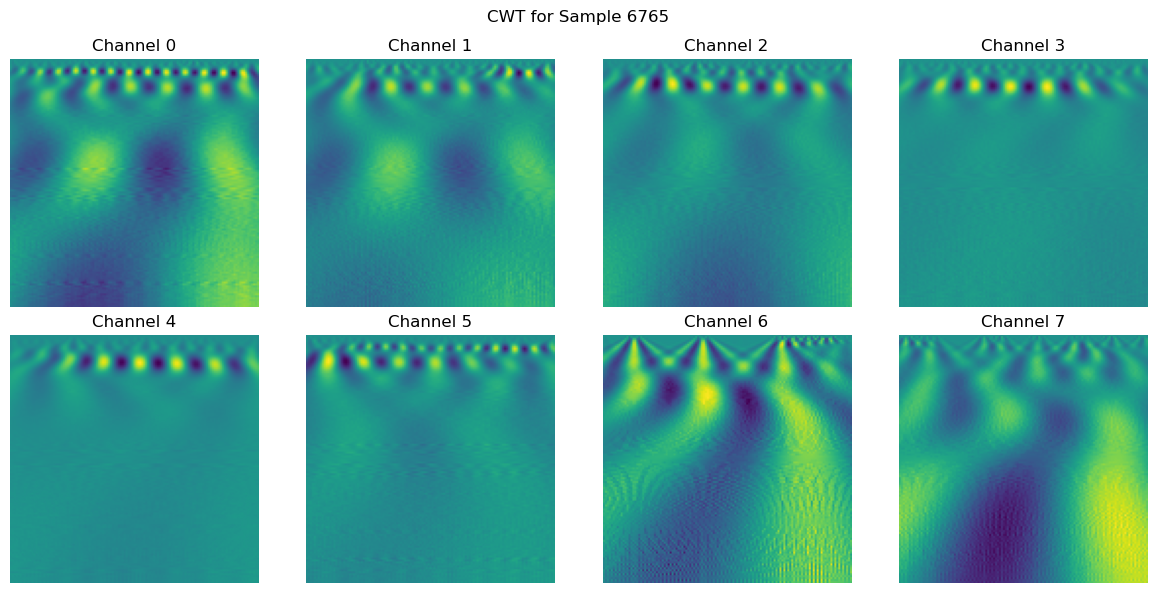

In [13]:
# Choose a random sample index
sample_index = random.randint(0, x_train.shape[0] - 1)

# Plot the CWT images for all channels in that sample
plt.figure(figsize=(12, 6))
for ch in range(x_train.shape[3]):  # Automatically use available channels
    plt.subplot(2, 4, ch + 1)
    plt.imshow(x_train[sample_index, :, :, ch], cmap='viridis')
    plt.title(f'Channel {ch}')
    plt.axis('off')
plt.suptitle(f'CWT for Sample {sample_index}')
plt.tight_layout()
plt.show()

In [15]:
# Load the saved dictionary
data = torch.load("cwt_handgestures_dataset.pt", map_location=device)  # or 'device' if using GPU/MPS

# Unpack the contents into variables
x_train = data["x_train"]
y_train = data["y_train"]
x_test = data["x_test"]
y_test = data["y_test"]
label_dict = data["label_dict"]

# Machine Learning

This will use Pytorch to do training on the dataset pre-processed into sonographs. This is memory-optimized to ensure that MPS does
not have problems with memory leaking, and ensure that we can maintain a large enough batch size.

If MPS is possible, then that device feature will be used. This will offload much of the training to the graphics cores, but some of
The main processor will still be used for training, especially in the beginning. This is a memory-intensive task, and expect the memory pressure at first to be near 50GB, but it does reduce down to approximately 20GB after dataloading. This will be intensive on any machine that does not have 32GB of memory.

This training will run for ten epochs, to ensure that we can reach a high enough accuracy with the test dataset (validation data)

In [19]:
# Memory Configuration (must come first)
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
os.environ['PYTORCH_MPS_MAX_CACHE_SIZE'] = '0'

# Memory monitoring function
def print_memory_stats(prefix=""):
    if torch.backends.mps.is_available():
        allocated = torch.mps.current_allocated_memory()/1e9
        reserved = torch.mps.driver_allocated_memory()/1e9
        print(f"{prefix} Memory: Alloc={allocated:.2f}GB, Reserved={reserved:.2f}GB")

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
if torch.backends.mps.is_available():
    torch.mps.manual_seed(42)
    torch.mps.set_per_process_memory_fraction(1.0)

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
print_memory_stats("Initial")

# Parameters
input_shape = (127, 127, 8) # Based on the number of CWT channels
batch_size = 16
num_classes = 81
epochs = 10
accumulation_steps = 2

# Label mapping
y_all = np.concatenate([y_train, y_test])
unique_labels = sorted(set(y_all))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# y_train_indices = np.array([label_to_index[label] for label in y_train])
# y_test_indices = np.array([label_to_index[label] for label in y_test])

y_train_indices = np.array([label_to_index[label.item()] for label in y_train])
y_test_indices = np.array([label_to_index[label.item()] for label in y_test])

# Normalize and permute input
def normalize(tensor):
    mean = tensor.mean(dim=(2, 3), keepdim=True)
    std = tensor.std(dim=(2, 3), keepdim=True) + 1e-6
    return (tensor - mean) / std

# x_train_tensor = normalize(torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2))
# x_test_tensor = normalize(torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2))

x_train_tensor = normalize(x_train.float().permute(0, 3, 1, 2))
x_test_tensor = normalize(x_test.float().permute(0, 3, 1, 2))
y_train_tensor = torch.tensor(y_train_indices, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_indices, dtype=torch.long)

# MPS-Optimized Lightweight CNN
class MPSCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=3, padding=1, groups=8),
            nn.Conv2d(8, 32, kernel_size=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1, groups=32),
            nn.Conv2d(32, 64, kernel_size=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 64, kernel_size=3, padding=1, groups=64),
            nn.Conv2d(64, 128, kernel_size=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 15 * 15, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model = MPSCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(TensorDataset(x_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_tensor, y_test_tensor), batch_size=batch_size)

history = defaultdict(list)
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_loss, correct, total = 0.0, 0, 0
    epoch_start = time()

    for batch_idx, (inputs, labels) in enumerate(train_loader):

        # print(f"Batch {batch_idx} labels:", labels)
        outputs = model(inputs.to(device))
        _, predicted = torch.max(outputs.data, 1)
        # print(f"Batch {batch_idx} predicted:", predicted.cpu())
        # break

        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels) / accumulation_steps
        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        train_loss += loss.item() * accumulation_steps
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # if batch_idx % 200 == 0:
        #     print_memory_stats(f"Batch {batch_idx}")

        if batch_idx % 10 == 0:
            torch.mps.empty_cache()
            gc.collect()

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    history['train_loss'].append(train_loss/len(train_loader))
    history['train_acc'].append(correct/total)
    history['val_loss'].append(val_loss/len(test_loader))
    history['val_acc'].append(val_correct/val_total)

    print(f"Epoch {epoch+1}/{epochs} - {time()-epoch_start:.1f}s")
    print(f"Train Loss: {history['train_loss'][-1]:.4f} Acc: {history['train_acc'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f} Acc: {history['val_acc'][-1]:.4f}")
    print_memory_stats("Epoch End")
    print()

def safe_evaluate(model, inputs, labels, chunk_size=8):
    model.eval()
    total_loss, correct = 0.0, 0
    with torch.no_grad():
        for i in range(0, inputs.size(0), chunk_size):
            chunk_inputs = inputs[i:i+chunk_size].to(device)
            chunk_labels = labels[i:i+chunk_size].to(device)

            outputs = model(chunk_inputs)
            total_loss += criterion(outputs, chunk_labels).item() * chunk_inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == chunk_labels).sum().item()
            torch.mps.empty_cache()

    return total_loss/inputs.size(0), correct/inputs.size(0)

train_loss, train_acc = safe_evaluate(model, x_train_tensor, y_train_tensor)
test_loss, test_acc = safe_evaluate(model, x_test_tensor, y_test_tensor)

print('Final Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')
print_memory_stats("Final")

Using device: mps
Initial Memory: Alloc=7.96GB, Reserved=17.92GB


/var/folders/b0/gfhb3q152fj7dx14t68p8cch0000gn/T/ipykernel_3074/1337559286.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = normalize(torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2))
/var/folders/b0/gfhb3q152fj7dx14t68p8cch0000gn/T/ipykernel_3074/1337559286.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = normalize(torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2))


Epoch 1/10 - 27.5s
Train Loss: 0.9369 Acc: 0.8057
Val Loss: 0.2840 Acc: 0.9639
Epoch End Memory: Alloc=0.10GB, Reserved=2.03GB

Epoch 2/10 - 24.5s
Train Loss: 0.2676 Acc: 0.9652
Val Loss: 0.2253 Acc: 0.9707
Epoch End Memory: Alloc=0.10GB, Reserved=2.03GB

Epoch 3/10 - 24.6s
Train Loss: 0.2096 Acc: 0.9689
Val Loss: 0.2112 Acc: 0.9720
Epoch End Memory: Alloc=0.10GB, Reserved=2.03GB

Epoch 4/10 - 24.8s
Train Loss: 0.1894 Acc: 0.9719
Val Loss: 0.2039 Acc: 0.9717
Epoch End Memory: Alloc=0.10GB, Reserved=2.03GB

Epoch 5/10 - 24.8s
Train Loss: 0.1735 Acc: 0.9718
Val Loss: 0.2021 Acc: 0.9720
Epoch End Memory: Alloc=0.10GB, Reserved=2.03GB

Epoch 6/10 - 24.8s
Train Loss: 0.1716 Acc: 0.9731
Val Loss: 0.2007 Acc: 0.9730
Epoch End Memory: Alloc=0.10GB, Reserved=2.03GB

Epoch 7/10 - 24.9s
Train Loss: 0.1643 Acc: 0.9735
Val Loss: 0.1985 Acc: 0.9738
Epoch End Memory: Alloc=0.10GB, Reserved=2.03GB

Epoch 8/10 - 24.8s
Train Loss: 0.1597 Acc: 0.9747
Val Loss: 0.2240 Acc: 0.9725
Epoch End Memory: Alloc=0

## Save Model

Save the trained model for later use

In [20]:
# Save the model
torch.save(model.state_dict(), "handgestures_trained_model_weights_97percent.pt")

# Save the history (loss and accuracy)
df_history = pd.DataFrame(history)
df_history.to_csv("handgestures_training_history.csv", index=False)

## Inspect Size and Shape

We will inspect the size and shape of the data and tensors, so that we can determine what kind of samples we have to train

In [21]:
print("x_train shape:", x_train.shape)
print("x_train_tensor shape:", x_train_tensor.shape)
print("x_train_tensor stats: mean =", x_train_tensor.mean().item(), "std =", x_train_tensor.std().item())
print("Sample input min/max:", x_train_tensor[0].min().item(), x_train_tensor[0].max().item())

x_train shape: torch.Size([15420, 127, 127, 8])
x_train_tensor shape: torch.Size([15420, 8, 127, 127])
x_train_tensor stats: mean = 1.1779571242043207e-11 std = 0.9998869299888611
Sample input min/max: -5.922956943511963 5.4239912033081055


# Validations
---

## Convert CWTs for UCI HAR

We need to convert the wavelet sonographs into 6 channels instead of 8 channels

In [51]:
# CWT parameters
scales = range(1, 128)
waveletname = 'morl'

# Device setup (prefer MPS if available)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# print(os.getcwd())

def normalize_signal(data):
    return (data - data.mean(axis=0)) / (data.std(axis=0) + 1e-6)

def extract_tensor_from_csv(csv_path, target_len=127):
    # print('CSV path:')
    # print(csv_path)
    df = pd.read_csv(csv_path)
    cols = ['AccelX(g)', 'AccelY(g)', 'AccelZ(g)', 
            'GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)']
    data = df[cols].values
    data = normalize_signal(data)

    # Pad or truncate to fixed length
    if len(data) >= target_len:
        data = data[:target_len, :]
    else:
        pad_width = target_len - len(data)
        pad = np.zeros((pad_width, data.shape[1]), dtype=np.float32)
        data = np.vstack([data, pad])
        
    return data.astype(np.float32)  # Final shape: (127, 8)

def compute_cwt(signal_1d):
    coeff, _ = pywt.cwt(signal_1d.cpu().numpy(), scales, waveletname, 1)
    return torch.from_numpy(coeff[:, :127]).float().to(device)

def process_dataset_tensor(data, batch_size=32):
    num_samples, signal_length, num_channels = data.shape
    result = torch.zeros((num_samples, 127, 127, num_channels), device=device)

    for ch in range(num_channels):
        print(f"Processing channel {ch+1}/{num_channels}")
        for i in tqdm(range(0, num_samples, batch_size)):
            batch = data[i:i+batch_size, :, ch]
            batch_tensor = torch.from_numpy(batch).float().to(device)
            for k in range(batch_tensor.shape[0]):
                result[i + k, :, :, ch] = compute_cwt(batch_tensor[k])
    return result.cpu().numpy()

def load_and_split_dataset(root_dir, train_ratio=0.8, seed=42):
    samples = []
    labels = []
    label_to_index = {}
    file_paths = []

    for root, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".csv") or file.endswith(".CSV"):
                path = os.path.join(root, file)
                path_parts = os.path.normpath(root).split(os.sep)
                if len(path_parts) < 2:
                    continue
                classifier, behavior = path_parts[-2], path_parts[-1]
                label = f"{classifier}_{behavior}"
                if label not in label_to_index:
                    label_to_index[label] = len(label_to_index)
                file_paths.append((path, label_to_index[label]))

    # Shuffle and split
    paths, labels = zip(*file_paths)
    paths = np.array(paths)
    labels = np.array(labels)
    # for k, v in label_to_index.items(): print(f'Name: {k}, Label: {v}')
    import json

    # Assuming label_to_index is already populated
    with open("label_index_map.json", "w") as f:
        json.dump(label_to_index, f, indent=4)
    
    print("Label-to-index mapping saved to label_index_map.json")

    print(f'This is the number of CSV files detected: {len(paths)}')
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        paths, labels, train_size=train_ratio, random_state=seed, stratify=labels
    )

    def load_batch(paths):
        return np.stack([extract_tensor_from_csv(p) for p in paths])

    print("Loading training data...")
    train_data = load_batch(train_paths)
    print("Loading test data...")
    test_data = load_batch(test_paths)

    return train_data, train_labels, test_data, test_labels, label_to_index

# Change this to your full dataset root
full_dataset_root = "data-collections"

train_data, train_labels, test_data, test_labels, label_dict = load_and_split_dataset(full_dataset_root)

# Convert numpy arrays to tensors (optional but helpful for consistency)
raw_dataset = {
    "train_data": torch.tensor(train_data),        # shape: (N, 127, 8)
    "train_labels": torch.tensor(train_labels),    # shape: (N,)
    "test_data": torch.tensor(test_data),          # shape: (M, 127, 8)
    "test_labels": torch.tensor(test_labels),      # shape: (M,)
    "label_dict": label_dict                       # dict: str -> int
}

torch.save(raw_dataset, "raw_handgestures_6channels_dataset.pt")
print("Raw dataset saved to raw_handsgestures_6channels_dataset.pt")

print("\nProcessing CWT for training data...")
x_train = process_dataset_tensor(train_data)
y_train = train_labels[:len(x_train)]

print("\nProcessing CWT for test data...")
x_test = process_dataset_tensor(test_data)
y_test = test_labels[:len(x_test)]

print("\nCWT Processing complete. Saving data state for 6 channels...")
torch.save({
    "x_train": torch.tensor(x_train),
    "y_train": torch.tensor(y_train),
    "x_test": torch.tensor(x_test),
    "y_test": torch.tensor(y_test),
    "label_dict": label_dict
}, "cwt_handgestures_6channels_dataset.pt")

# Final shapes
print(f"\nx_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

Using device: mps
Label-to-index mapping saved to label_index_map.json
This is the number of CSV files detected: 19275
Loading training data...
Loading test data...
Raw dataset saved to raw_handsgestures_6channels_dataset.pt

Processing CWT for training data...
Processing channel 1/6


100%|█████████████████████████████████████████| 482/482 [00:55<00:00,  8.69it/s]


Processing channel 2/6


100%|█████████████████████████████████████████| 482/482 [00:55<00:00,  8.71it/s]


Processing channel 3/6


100%|█████████████████████████████████████████| 482/482 [00:53<00:00,  8.93it/s]


Processing channel 4/6


100%|█████████████████████████████████████████| 482/482 [00:54<00:00,  8.89it/s]


Processing channel 5/6


100%|█████████████████████████████████████████| 482/482 [00:53<00:00,  8.96it/s]


Processing channel 6/6


100%|█████████████████████████████████████████| 482/482 [00:54<00:00,  8.89it/s]



Processing CWT for test data...
Processing channel 1/6


100%|█████████████████████████████████████████| 121/121 [00:14<00:00,  8.17it/s]


Processing channel 2/6


100%|█████████████████████████████████████████| 121/121 [00:13<00:00,  8.94it/s]


Processing channel 3/6


100%|█████████████████████████████████████████| 121/121 [00:13<00:00,  9.01it/s]


Processing channel 4/6


100%|█████████████████████████████████████████| 121/121 [00:13<00:00,  9.14it/s]


Processing channel 5/6


100%|█████████████████████████████████████████| 121/121 [00:13<00:00,  9.07it/s]


Processing channel 6/6


100%|█████████████████████████████████████████| 121/121 [00:13<00:00,  8.99it/s]



CWT Processing complete. Saving data state for 6 channels...

x_train shape: (15420, 127, 127, 6)
y_train shape: (15420,)
x_test shape: (3855, 127, 127, 6)
y_test shape: (3855,)


In [57]:
# CWT parameters
scales = range(1, 128)
waveletname = 'morl'

# Device setup (prefer MPS if available)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

def normalize_signal(data):
    return (data - data.mean(axis=0)) / (data.std(axis=0) + 1e-6)

def extract_tensor_from_csv(csv_path, target_len=127):
    df = pd.read_csv(csv_path)
    cols = ['AccelX(g)', 'AccelY(g)', 'AccelZ(g)', 
            'GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)']
    data = df[cols].values
    data = normalize_signal(data)

    # Pad or truncate to fixed length
    if len(data) >= target_len:
        data = data[:target_len, :]
    else:
        pad_width = target_len - len(data)
        pad = np.zeros((pad_width, data.shape[1]), dtype=np.float32)
        data = np.vstack([data, pad])
        
    return data.astype(np.float32)  # Shape: (127, 6)

def compute_cwt(signal_1d):
    coeff, _ = pywt.cwt(signal_1d.cpu().numpy(), scales, waveletname, 1)
    return torch.from_numpy(coeff[:, :127]).float().to(device)

def process_dataset_tensor(data, batch_size=32):
    num_samples, signal_length, num_channels = data.shape
    result = torch.zeros((num_samples, 127, 127, num_channels), device=device)

    for ch in range(num_channels):
        print(f"Processing channel {ch+1}/{num_channels}")
        for i in tqdm(range(0, num_samples, batch_size)):
            batch = data[i:i+batch_size, :, ch]
            batch_tensor = torch.from_numpy(batch).float().to(device)
            for k in range(batch_tensor.shape[0]):
                result[i + k, :, :, ch] = compute_cwt(batch_tensor[k])
    return result.cpu().numpy()

def compute_psd_for_signal(signal_1d, fs=50, nperseg=64):
    # fs: sample rate (Hz), adjust as needed
    # Returns PSD vector of fixed length
    freqs, psd = welch(signal_1d, fs=fs, nperseg=nperseg)
    return psd

def process_psd_dataset(data):
    # data shape: (num_samples, time_steps, channels)
    num_samples, _, num_channels = data.shape
    
    # We'll fix PSD length to length of Welch output; compute once to get size
    example_psd = compute_psd_for_signal(data[0, :, 0])
    psd_length = len(example_psd)
    
    psd_dataset = np.zeros((num_samples, psd_length, num_channels), dtype=np.float32)
    
    print("Processing PSD for each sample and channel...")
    for i in tqdm(range(num_samples)):
        for ch in range(num_channels):
            signal = data[i, :, ch]
            psd = compute_psd_for_signal(signal)
            psd_dataset[i, :, ch] = psd
    
    return psd_dataset

def load_and_split_dataset(root_dir, train_ratio=0.8, seed=42):
    samples = []
    labels = []
    label_to_index = {}
    file_paths = []

    for root, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".csv") or file.endswith(".CSV"):
                path = os.path.join(root, file)
                path_parts = os.path.normpath(root).split(os.sep)
                if len(path_parts) < 2:
                    continue
                classifier, behavior = path_parts[-2], path_parts[-1]
                label = f"{classifier}_{behavior}"
                if label not in label_to_index:
                    label_to_index[label] = len(label_to_index)
                file_paths.append((path, label_to_index[label]))

    # Shuffle and split
    paths, labels = zip(*file_paths)
    paths = np.array(paths)
    labels = np.array(labels)

    import json
    with open("label_index_map.json", "w") as f:
        json.dump(label_to_index, f, indent=4)
    print("Label-to-index mapping saved to label_index_map.json")

    print(f'This is the number of CSV files detected: {len(paths)}')
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        paths, labels, train_size=train_ratio, random_state=seed, stratify=labels
    )

    def load_batch(paths):
        return np.stack([extract_tensor_from_csv(p) for p in paths])

    print("Loading training data...")
    train_data = load_batch(train_paths)
    print("Loading test data...")
    test_data = load_batch(test_paths)

    return train_data, train_labels, test_data, test_labels, label_to_index

# Change this to your full dataset root
full_dataset_root = "data-collections"

train_data, train_labels, test_data, test_labels, label_dict = load_and_split_dataset(full_dataset_root)

# Save raw dataset (optional)
raw_dataset = {
    "train_data": torch.tensor(train_data),        # shape: (N, 127, 6)
    "train_labels": torch.tensor(train_labels),    # shape: (N,)
    "test_data": torch.tensor(test_data),          # shape: (M, 127, 6)
    "test_labels": torch.tensor(test_labels),      # shape: (M,)
    "label_dict": label_dict                         # dict: str -> int
}
torch.save(raw_dataset, "raw_handgestures_6channels_dataset.pt")
print("Raw dataset saved to raw_handgestures_6channels_dataset.pt")

# --- PSD Dataset creation ---
psd_train = process_psd_dataset(train_data)  # shape (N, psd_len, 6)
psd_test = process_psd_dataset(test_data)    # shape (M, psd_len, 6)

torch.save({
    "psd_train": torch.tensor(psd_train),
    "train_labels": torch.tensor(train_labels),
    "psd_test": torch.tensor(psd_test),
    "test_labels": torch.tensor(test_labels),
    "label_dict": label_dict
}, "psd_handgestures_6channels_dataset.pt")
print("PSD dataset saved to psd_handgestures_6channels_dataset.pt")

# --- CWT Processing ---
print("\nProcessing CWT for training data...")
x_train = process_dataset_tensor(train_data)
y_train = train_labels[:len(x_train)]

print("\nProcessing CWT for test data...")
x_test = process_dataset_tensor(test_data)
y_test = test_labels[:len(x_test)]

print("\nCWT Processing complete. Saving data state for 6 channels...")
torch.save({
    "x_train": torch.tensor(x_train),
    "y_train": torch.tensor(y_train),
    "x_test": torch.tensor(x_test),
    "y_test": torch.tensor(y_test),
    "label_dict": label_dict
}, "cwt_handgestures_6channels_dataset.pt")

# Final shapes
print(f"\nx_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


Using device: mps
Label-to-index mapping saved to label_index_map.json
This is the number of CSV files detected: 19275
Loading training data...
Loading test data...
Raw dataset saved to raw_handgestures_6channels_dataset.pt
Processing PSD for each sample and channel...


100%|███████████████████████████████████| 15420/15420 [00:05<00:00, 3031.88it/s]


Processing PSD for each sample and channel...


100%|█████████████████████████████████████| 3855/3855 [00:01<00:00, 3088.41it/s]


PSD dataset saved to psd_handgestures_6channels_dataset.pt

Processing CWT for training data...
Processing channel 1/6


100%|█████████████████████████████████████████| 482/482 [00:55<00:00,  8.71it/s]


Processing channel 2/6


100%|█████████████████████████████████████████| 482/482 [00:54<00:00,  8.92it/s]


Processing channel 3/6


100%|█████████████████████████████████████████| 482/482 [00:54<00:00,  8.91it/s]


Processing channel 4/6


100%|█████████████████████████████████████████| 482/482 [00:53<00:00,  8.93it/s]


Processing channel 5/6


100%|█████████████████████████████████████████| 482/482 [00:54<00:00,  8.91it/s]


Processing channel 6/6


100%|█████████████████████████████████████████| 482/482 [00:53<00:00,  8.96it/s]



Processing CWT for test data...
Processing channel 1/6


100%|█████████████████████████████████████████| 121/121 [00:13<00:00,  8.83it/s]


Processing channel 2/6


100%|█████████████████████████████████████████| 121/121 [00:13<00:00,  8.97it/s]


Processing channel 3/6


100%|█████████████████████████████████████████| 121/121 [00:13<00:00,  8.98it/s]


Processing channel 4/6


100%|█████████████████████████████████████████| 121/121 [00:13<00:00,  9.03it/s]


Processing channel 5/6


100%|█████████████████████████████████████████| 121/121 [00:13<00:00,  9.07it/s]


Processing channel 6/6


100%|█████████████████████████████████████████| 121/121 [00:13<00:00,  9.05it/s]



CWT Processing complete. Saving data state for 6 channels...

x_train shape: (15420, 127, 127, 6)
y_train shape: (15420,)
x_test shape: (3855, 127, 127, 6)
y_test shape: (3855,)


In [3]:
# Load the saved dictionary
data = torch.load("cwt_handgestures_6channels_dataset.pt", map_location="cpu")  # or 'device' if using GPU/MPS

# Unpack the contents into variables
x_train = data["x_train"]
y_train = data["y_train"]
x_test = data["x_test"]
y_test = data["y_test"]
label_dict = data["label_dict"]

In [12]:
# New version of ML Model with CNN based on CWT Sonograms, and LSTM for temporal analysis

# Memory Configuration (must come first)
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
os.environ['PYTORCH_MPS_MAX_CACHE_SIZE'] = '0'

# Memory monitoring function
def print_memory_stats(prefix=""):
    if torch.backends.mps.is_available():
        allocated = torch.mps.current_allocated_memory() / 1e9
        reserved = torch.mps.driver_allocated_memory() / 1e9
        print(f"{prefix} Memory: Alloc={allocated:.2f}GB, Reserved={reserved:.2f}GB")

# Device and seed setup
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
if torch.backends.mps.is_available():
    torch.mps.manual_seed(42)
    torch.mps.set_per_process_memory_fraction(1.0)

print(f"Using device: {device}")
print_memory_stats("Initial")

# Parameters
input_shape = (127, 127, 6)
batch_size = 16
num_classes = 81
epochs = 10
accumulation_steps = 2
time_steps = 8  # number of temporal slices per sample

# Assume x_train, x_test, y_train, y_test are defined elsewhere
# For example, x_train shape: (N, 127, 127, 6)
# y_train shape: (N,)
# Make sure data is torch tensor or numpy array accordingly

# Mapping labels to indices
y_all = np.concatenate([y_train, y_test])
index_to_label = {label: idx for idx, label in enumerate(sorted(set(y_all)))}
y_train_indices = np.array([index_to_label[label.item()] if hasattr(label, 'item') else index_to_label[label] for label in y_train])
y_test_indices = np.array([index_to_label[label.item()] if hasattr(label, 'item') else index_to_label[label] for label in y_test])

def normalize(tensor):
    mean = tensor.mean(dim=(2, 3), keepdim=True)
    std = tensor.std(dim=(2, 3), keepdim=True) + 1e-6
    return (tensor - mean) / std

# x_train_tensor = normalize(torch.tensor(x_train).float().permute(0, 3, 1, 2))  # (N, C, H, W)
# x_test_tensor = normalize(torch.tensor(x_test).float().permute(0, 3, 1, 2))
x_train_tensor = normalize(x_train.detach().clone().float().permute(0, 3, 1, 2))
x_test_tensor = normalize(x_test.detach().clone().float().permute(0, 3, 1, 2))
y_train_tensor = torch.tensor(y_train_indices, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_indices, dtype=torch.long)

def pad_to_multiple(tensor, multiple, dim=0, pad_value=0):
    """
    Pads tensor along dimension `dim` to a size that is a multiple of `multiple`.
    """
    size = tensor.size(dim)
    remainder = size % multiple
    if remainder == 0:
        return tensor  # no padding needed
    padding_size = multiple - remainder
    pad_shape = list(tensor.shape)
    pad_shape[dim] = padding_size
    pad_tensor = torch.full(pad_shape, pad_value, dtype=tensor.dtype, device=tensor.device)
    return torch.cat([tensor, pad_tensor], dim=dim)

# Pad datasets so total samples are divisible by time_steps
x_train_tensor = pad_to_multiple(x_train_tensor, time_steps, dim=0, pad_value=0)
x_test_tensor = pad_to_multiple(x_test_tensor, time_steps, dim=0, pad_value=0)
y_train_tensor = pad_to_multiple(y_train_tensor, time_steps, dim=0, pad_value=-100)  # Use ignore_index -100 for padding labels
y_test_tensor = pad_to_multiple(y_test_tensor, time_steps, dim=0, pad_value=-100)

# Reshape to (batch, time_steps, channels, H, W)
num_train_batches = x_train_tensor.size(0) // time_steps
num_test_batches = x_test_tensor.size(0) // time_steps

x_train_seq = x_train_tensor.view(num_train_batches, time_steps, *input_shape[::-1])  # input_shape[::-1] flips (H,W,C) -> (C,H,W)
y_train_seq = y_train_tensor.view(num_train_batches, time_steps)

x_test_seq = x_test_tensor.view(num_test_batches, time_steps, *input_shape[::-1])
y_test_seq = y_test_tensor.view(num_test_batches, time_steps)

# We only use the label of the last timestep for training/classification
y_train_seq_last = y_train_seq[:, -1]
y_test_seq_last = y_test_seq[:, -1]

# Model definition
class CNNLSTM(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNNLSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 63x63

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 31x31

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 15x15
        )
        # Infer CNN output size dynamically
        dummy_input = torch.zeros(1, input_channels, input_shape[0], input_shape[1])
        cnn_output_dim = self.cnn(dummy_input).view(1, -1).size(1)

        self.lstm = nn.LSTM(input_size=cnn_output_dim, hidden_size=128,
                            batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(128 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x shape: (B, T, C, H, W)
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)  # combine batch and time for CNN
        x = self.cnn(x)
        x = x.view(B, T, -1)  # separate batch and time
        out, _ = self.lstm(x)
        # Use output of last timestep
        return self.classifier(out[:, -1, :])

model = CNNLSTM(input_channels=6, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-100)  # ignore padded labels in loss
optimizer = Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(TensorDataset(x_train_seq, y_train_seq_last), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_seq, y_test_seq_last), batch_size=batch_size)

history = defaultdict(list)
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_loss, correct, total = 0.0, 0, 0
    epoch_start = time.time()

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels) / accumulation_steps
        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        train_loss += loss.item() * accumulation_steps
        _, predicted = torch.max(outputs.data, 1)
        mask = labels != -100  # only count non-padded labels
        correct += (predicted[mask] == labels[mask]).sum().item()
        total += mask.sum().item()

        if batch_idx % 10 == 0:
            torch.mps.empty_cache()
            gc.collect()

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            mask = labels != -100
            val_correct += (predicted[mask] == labels[mask]).sum().item()
            val_total += mask.sum().item()

    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(correct / total if total > 0 else 0)
    history['val_loss'].append(val_loss / len(test_loader))
    history['val_acc'].append(val_correct / val_total if val_total > 0 else 0)

    print(f"Epoch {epoch + 1}/{epochs} - {time.time() - epoch_start:.1f}s")
    print(f"Train Loss: {history['train_loss'][-1]:.4f} Acc: {history['train_acc'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f} Acc: {history['val_acc'][-1]:.4f}")
    print_memory_stats("Epoch End")
    print()

def safe_evaluate(model, inputs, labels, chunk_size=8):
    model.eval()
    total_loss, correct = 0.0, 0
    with torch.no_grad():
        for i in range(0, inputs.size(0), chunk_size):
            chunk_inputs = inputs[i:i + chunk_size].to(device)
            chunk_labels = labels[i:i + chunk_size].to(device)

            outputs = model(chunk_inputs)
            total_loss += criterion(outputs, chunk_labels).item() * chunk_inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            mask = chunk_labels != -100
            correct += (predicted[mask] == chunk_labels[mask]).sum().item()
            torch.mps.empty_cache()

    return total_loss / inputs.size(0), correct / inputs.size(0)

train_loss, train_acc = safe_evaluate(model, x_train_seq, y_train_seq_last)
test_loss, test_acc = safe_evaluate(model, x_test_seq, y_test_seq_last)

print('Final Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')
print_memory_stats("Final")

Using device: mps
Initial Memory: Alloc=0.64GB, Reserved=2.17GB
Epoch 1/10 - 11.9s
Train Loss: 3.4909 Acc: 0.1085
Val Loss: 3.1190 Acc: 0.1247
Epoch End Memory: Alloc=0.64GB, Reserved=2.42GB

Epoch 2/10 - 10.0s
Train Loss: 3.1521 Acc: 0.1308
Val Loss: 3.0506 Acc: 0.1247
Epoch End Memory: Alloc=0.64GB, Reserved=2.42GB

Epoch 3/10 - 10.2s
Train Loss: 3.1146 Acc: 0.1277
Val Loss: 3.0144 Acc: 0.1372
Epoch End Memory: Alloc=0.64GB, Reserved=2.42GB

Epoch 4/10 - 9.9s
Train Loss: 2.9117 Acc: 0.2102
Val Loss: 2.6724 Acc: 0.2412
Epoch End Memory: Alloc=0.64GB, Reserved=2.42GB

Epoch 5/10 - 10.2s
Train Loss: 2.3698 Acc: 0.3518
Val Loss: 1.9434 Acc: 0.5593
Epoch End Memory: Alloc=0.64GB, Reserved=2.42GB

Epoch 6/10 - 9.8s
Train Loss: 1.6403 Acc: 0.5656
Val Loss: 1.2639 Acc: 0.7380
Epoch End Memory: Alloc=0.64GB, Reserved=2.42GB

Epoch 7/10 - 10.1s
Train Loss: 1.0832 Acc: 0.7582
Val Loss: 0.8476 Acc: 0.8669
Epoch End Memory: Alloc=0.64GB, Reserved=2.42GB

Epoch 8/10 - 10.1s
Train Loss: 0.7184 Acc:

In [ ]:
# Augmented version with PSD fusion branch into the CNN+LSTM model

import os
import gc
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import numpy as np
from collections import defaultdict

# Memory Configuration (must come first)
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
os.environ['PYTORCH_MPS_MAX_CACHE_SIZE'] = '0'

def print_memory_stats(prefix=""):
    if torch.backends.mps.is_available():
        allocated = torch.mps.current_allocated_memory() / 1e9
        reserved = torch.mps.driver_allocated_memory() / 1e9
        print(f"{prefix} Memory: Alloc={allocated:.2f}GB, Reserved={reserved:.2f}GB")

# Device and seed setup
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
if torch.backends.mps.is_available():
    torch.mps.manual_seed(42)
    torch.mps.set_per_process_memory_fraction(1.0)

print(f"Using device: {device}")
print_memory_stats("Initial")

# Parameters
input_shape = (127, 127, 6)
batch_size = 16
num_classes = 81
epochs = 10
accumulation_steps = 2
time_steps = 8
psd_vector_dim = 6 * 64  # assuming 64 bins per 6 channels

# Assume x_train_seq, x_test_seq, y_train_seq_last, y_test_seq_last, psd_train_seq, psd_test_seq are already defined

# Model with PSD branch
class CNNLSTMWithPSD(nn.Module):
    def __init__(self, input_channels, psd_dim, num_classes):
        super(CNNLSTMWithPSD, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        dummy_input = torch.zeros(1, input_channels, input_shape[0], input_shape[1])
        cnn_output_dim = self.cnn(dummy_input).view(1, -1).size(1)

        self.lstm = nn.LSTM(input_size=cnn_output_dim, hidden_size=128, batch_first=True, bidirectional=True)
        self.psd_branch = nn.Sequential(
            nn.Linear(psd_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 2 + 64, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x, psd):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        x = self.cnn(x)
        x = x.view(B, T, -1)
        out, _ = self.lstm(x)
        cnn_lstm_out = out[:, -1, :]  # final timestep
        psd_out = self.psd_branch(psd)
        fused = torch.cat([cnn_lstm_out, psd_out], dim=1)
        return self.classifier(fused)

model = CNNLSTMWithPSD(input_channels=6, psd_dim=psd_vector_dim, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(TensorDataset(x_train_seq, psd_train_seq, y_train_seq_last), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_seq, psd_test_seq, y_test_seq_last), batch_size=batch_size)

history = defaultdict(list)
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_loss, correct, total = 0.0, 0, 0
    epoch_start = time.time()

    for batch_idx, (inputs, psds, labels) in enumerate(train_loader):
        inputs, psds, labels = inputs.to(device), psds.to(device), labels.to(device)
        outputs = model(inputs, psds)
        loss = criterion(outputs, labels) / accumulation_steps
        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        train_loss += loss.item() * accumulation_steps
        _, predicted = torch.max(outputs.data, 1)
        mask = labels != -100
        correct += (predicted[mask] == labels[mask]).sum().item()
        total += mask.sum().item()

        if batch_idx % 10 == 0:
            torch.mps.empty_cache()
            gc.collect()

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, psds, labels in test_loader:
            inputs, psds, labels = inputs.to(device), psds.to(device), labels.to(device)
            outputs = model(inputs, psds)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            mask = labels != -100
            val_correct += (predicted[mask] == labels[mask]).sum().item()
            val_total += mask.sum().item()

    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(correct / total if total > 0 else 0)
    history['val_loss'].append(val_loss / len(test_loader))
    history['val_acc'].append(val_correct / val_total if val_total > 0 else 0)

    print(f"Epoch {epoch + 1}/{epochs} - {time.time() - epoch_start:.1f}s")
    print(f"Train Loss: {history['train_loss'][-1]:.4f} Acc: {history['train_acc'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f} Acc: {history['val_acc'][-1]:.4f}")
    print_memory_stats("Epoch End")
    print()

## Save 6-channel Model

Save the trained reduced model for later use

In [13]:
# Save the model
torch.save(model.state_dict(), "handgestures_trained_6-channel_CNN-LSTM_model_weights_97percent.pt")

# Save the history (loss and accuracy)
df_history = pd.DataFrame(history)
df_history.to_csv("handgestures_6-channel_CNN-LSTM_training_history.csv", index=False)

## Inspect Size and Shape

We will inspect the size and shape of the data and tensors, so that we can determine what kind of samples we have to train

In [14]:
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("x_train_tensor shape:", x_train_tensor.shape)
print("x_train_tensor stats: mean =", x_train_tensor.mean().item(), "std =", x_train_tensor.std().item())
print("Sample input min/max:", x_train_tensor[0].min().item(), x_train_tensor[0].max().item())

x_train shape: torch.Size([15420, 127, 127, 6])
x_test shape: torch.Size([3855, 127, 127, 6])
x_train_tensor shape: torch.Size([15424, 6, 127, 127])
x_train_tensor stats: mean = 3.89074848727855e-11 std = 0.9998382925987244
Sample input min/max: -5.922956943511963 5.4239912033081055


# UCI HAR Dataset

We will use the UCI HAR dataset to validate our model against new wavelets that are based on gyroscope and accelerometer sensor readings. They are not from the same test, or from the same hardware, but the readings should be equivalent and will serve as a good test of our model's true accuracy.

In [15]:
def read_signals(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
        data = np.array(data, dtype=np.float32)
    return data
 
def read_labels(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(int, activities))
    return np.array(activities)
 
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
 
####
 
INPUT_FOLDER_TRAIN = './UCI_HAR/train/Inertial Signals/'
INPUT_FOLDER_TEST = './UCI_HAR/test/Inertial Signals/'
 
INPUT_FILES_TRAIN = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt']
 
INPUT_FILES_TEST = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
                     'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt']
 
#####
 
train_signals, test_signals = [], []
for input_file in INPUT_FILES_TRAIN:
    signal = read_signals(INPUT_FOLDER_TRAIN + input_file)
    train_signals.append(signal)
train_signals = np.transpose(np.array(train_signals), (1, 2, 0))
 
for input_file in INPUT_FILES_TEST:
    signal = read_signals(INPUT_FOLDER_TEST + input_file)
    test_signals.append(signal)
test_signals = np.transpose(np.array(test_signals), (1, 2, 0))
 
#####
 
LABELFILE_TRAIN = './UCI_HAR/train/y_train.txt'
LABELFILE_TEST = './UCI_HAR/test/y_test.txt'
train_labels = read_labels(LABELFILE_TRAIN)
test_labels = read_labels(LABELFILE_TEST)
 
#####
 
train_data, train_labels = randomize(train_signals, train_labels)
test_data, test_labels = randomize(test_signals, test_labels)

# Load activity labels into a dict {index: label_name}
activity_labels = {}
with open('./UCI_HAR/activity_labels.txt', 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) >= 2:
            idx = int(parts[0])
            label = " ".join(parts[1:])
            activity_labels[idx] = label

print(activity_labels)
# Example output: {1: 'WALKING', 2: 'WALKING_UPSTAIRS', ...}

{1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}


## Load the model

Load the model you want to test out the validation

In [16]:
# In a new script
#model = MPSCNN(num_classes)
# model.load_state_dict(torch.load("handgestures_trained_model_weights_97percent.pt", map_location=device))
# model = MPSCNN_6chan(num_classes)
# model.load_state_dict(torch.load("handgestures_trained_6-channel_model_weights_97percent.pt", map_location=device))

model = CNNLSTM(input_channels=6, num_classes=num_classes)
model.load_state_dict(torch.load("handgestures_trained_6-channel_CNN-LSTM_model_weights_97percent.pt", map_location=device))

model.to(device)

CNNLSTM(
  (cnn): Sequential(
    (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(28800, 128, batch_first=True, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=81, bias=True)
  )
)

## Random Prediction

Pick a random sample from the UCI HAR wavelets and do a prediction

In [55]:
def compute_cwt(signal_1d, device, scales=range(1, 128), wavelet='morl'):
    signal_np = signal_1d.cpu().numpy() if isinstance(signal_1d, torch.Tensor) else signal_1d
    coeff, _ = pywt.cwt(signal_np, scales, wavelet, 1)
    return torch.from_numpy(coeff[:, :127]).float().to(device)

def preprocess_sample(raw_sample, device, expected_channels=6):
    # Normalize each channel
    raw_sample = (raw_sample - raw_sample.mean(axis=0)) / (raw_sample.std(axis=0) + 1e-6)

    channels = []
    for i in range(raw_sample.shape[1]):
        cwt_tensor = compute_cwt(torch.tensor(raw_sample[:, i]), device)
        channels.append(cwt_tensor.unsqueeze(0))  # (1, height, width)

    stacked = torch.cat(channels, dim=0)  # (channels, height, width)

    if stacked.shape[0] < expected_channels:
        padding = torch.zeros((expected_channels - stacked.shape[0], 127, 127), device=device)
        stacked = torch.cat([stacked, padding], dim=0)
    elif stacked.shape[0] > expected_channels:
        stacked = stacked[:expected_channels]

    stacked = stacked.unsqueeze(0)  # Add batch dim: (1, channels, H, W)
    stacked = stacked.unsqueeze(1)  # Add time dim: (1, 1, channels, H, W)

    return stacked

def predict_single_sample(raw_sample, model, device, index_to_label=None):
    model_input = preprocess_sample(raw_sample, device, expected_channels=6)
    model.eval()
    with torch.no_grad():
        output = model(model_input.to(device))
        prediction = torch.argmax(output, dim=1).item()
    if index_to_label:
        return prediction, index_to_label[prediction]
    return prediction

# --- Random Sample Prediction Section ---
# Pick a random sample index
sample_index = random.randint(0, len(test_data) - 1)
sample = test_data[sample_index]
true_label_int = test_labels[sample_index] + 1  # Convert to 1-based for activity_labels
true_label_name = activity_labels.get(true_label_int, "Unknown")

# Predict
predicted_index, _ = predict_single_sample(sample, model, device, index_to_label)
predicted_label = next(k for k, v in label_dict.items() if v == predicted_index)

# Output
print(f"\nSample index: {sample_index}")
print(f"True label int: {true_label_int}")
print(f"True label name: {true_label_name}")
print(f"Predicted label index: {predicted_index}")
print(f"Predicted label name: {predicted_label}")


Sample index: 296
True label int: 3
True label name: WALKING_DOWNSTAIRS
Predicted label index: 58
Predicted label name: laying_variants


In [53]:
def normalize_sample(sample):
    """
    Normalize each channel in a sample (127, C) to zero mean and unit variance.
    Returns: normalized sample of shape (127, C)
    """
    mean = np.mean(sample, axis=0, keepdims=True)
    std = np.std(sample, axis=0, keepdims=True)
    std[std == 0] = 1e-6  # Prevent division by zero
    return (sample - mean) / std

def preprocess_batch(raw_batch, device, expected_channels=8):
    """
    raw_batch: numpy array (batch_size, 127, C)
    Returns: torch tensor (batch_size, 1, expected_channels, 127, 127)
    """
    batch_size = raw_batch.shape[0]
    processed = []
    for i in range(batch_size):
        norm_sample = normalize_sample(raw_batch[i])  # shape (127, C)
        sample_tensor = preprocess_sample(norm_sample, device, expected_channels)  # shape (1,1,C,H,W)
        processed.append(sample_tensor)
    return torch.cat(processed, dim=0)  # (batch_size, 1, expected_channels, 127, 127)

def predict_batch(raw_batch, raw_labels, model, device, index_to_label=None, label_dict=None):
    """
    raw_batch: numpy array (batch_size, 127, C)
    raw_labels: numpy array or list of true label indices (batch_size,)
    """
    model_input = preprocess_batch(raw_batch, device, expected_channels=6)
    model.eval()
    with torch.no_grad():
        outputs = model(model_input.to(device))  # (batch_size, num_classes)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

    # Map predictions to label names if label_dict provided
    index_to_label = {v: k for k, v in index_to_label.items()}
    pred_names = [index_to_label.get(p, "Unknown") for p in preds]

    # Map true labels to names if label_dict provided
    true_names = None
    if label_dict is not None and raw_labels is not None:
        true_names = [label_dict.get(lbl, "Unknown") for lbl in raw_labels]

    return preds, pred_names, raw_labels, true_names

# Usage example
batch_samples = test_data[:10]           # shape (10, 127, C)
batch_labels = test_labels[:10]           # shape (10,) true label indices

predicted_indices, predicted_labels, true_indices, true_labels = predict_batch(
    batch_samples, batch_labels, model, device, index_to_label=label_dict, label_dict=activity_labels)

print("Predicted indices:", predicted_indices)
print("Predicted labels:", predicted_labels)
print("True indices:", true_indices)
print("True labels:", true_labels)

Predicted indices: [58 56 56 56 52 58 58 58 58 56]
Predicted labels: ['laying_variants', 'sitting_variants', 'sitting_variants', 'sitting_variants', 'walking_variants', 'laying_variants', 'laying_variants', 'laying_variants', 'laying_variants', 'sitting_variants']
True indices: [3 6 2 4 1 5 2 4 4 5]
True labels: ['WALKING_DOWNSTAIRS', 'LAYING', 'WALKING_UPSTAIRS', 'SITTING', 'WALKING', 'STANDING', 'WALKING_UPSTAIRS', 'SITTING', 'SITTING', 'STANDING']


# Visualizations

Insights that were gathered from the data training and validation work

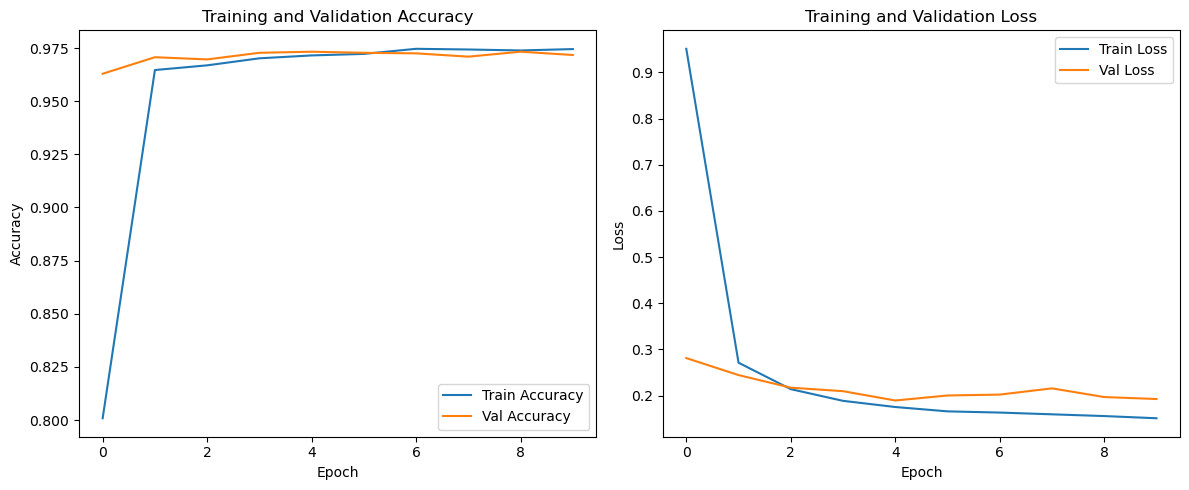

In [9]:
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


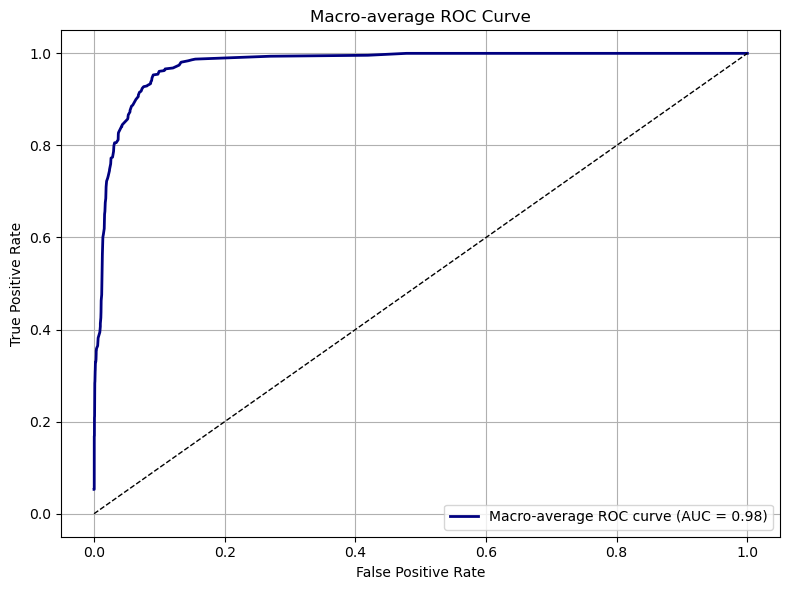

In [10]:
def compute_roc_auc(model, loader, n_classes):
    all_labels = []
    all_probs = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels.cpu().numpy())
            torch.mps.empty_cache()

    y_true = np.concatenate(all_labels)
    y_score = np.concatenate(all_probs)

    # One-hot encode the labels
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Macro-average ROC curve and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    return fpr, tpr, roc_auc

# Compute and plot ROC-AUC
fpr, tpr, roc_auc = compute_roc_auc(model, test_loader, num_classes)

plt.figure(figsize=(8, 6))
plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})', color='navy', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
unique_classes = np.unique(y_train)  # or use y_train_tensor.cpu().numpy()
print(unique_classes)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97]


In [15]:
class_to_index = {cls: idx for idx, cls in enumerate(sorted(unique_classes))}
print(class_to_index)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57, 58: 58, 59: 59, 60: 60, 61: 61, 62: 62, 63: 63, 64: 64, 65: 65, 66: 66, 67: 67, 68: 68, 69: 69, 70: 70, 71: 71, 72: 72, 73: 73, 74: 74, 75: 75, 76: 76, 77: 77, 78: 78, 79: 79, 80: 80, 81: 81, 82: 82, 83: 83, 84: 84, 85: 85, 86: 86, 87: 87, 88: 88, 89: 89, 90: 90, 91: 91, 92: 92, 93: 93, 94: 94, 95: 95, 96: 96, 97: 97}
